In [147]:
from torchvision import datasets, transforms
import torch
import matplotlib.pyplot as plt
from imgaug import augmenters as iaa
from torch.utils.data import DataLoader, Dataset

In [148]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [149]:
datafolder = './data'
fmnist = datasets.FashionMNIST(datafolder, download=True, train=True)

tr_images  = fmnist.data
tr_targets = fmnist.targets

In [150]:
# Affine transformation
scale_aug = iaa.Affine(scale=5, fit_output=True)
transx_aug = iaa.Affine(translate_px=10, fit_output=True)
transxy_aug = iaa.Affine(translate_px={'x':10, 'y':2}, fit_output=True)
rotate_aug = iaa.Affine(rotate=30, fit_output=True, cval=0)
shear_aug = iaa.Affine(shear=30, fit_output=True)

multiple_rotation = iaa.Affine(rotate=(-45, 45), fit_output=True, cval=0, mode="constant")

# changing brightness
mul_aug = iaa.Multiply(0.5)
linear_aug = iaa.LinearContrast(alpha=0.5) # 127 + alpha (pixel_value - 127)

# Blurring (for motion blur)
guassian_aug = iaa.GaussianBlur(sigma=1)

# noise
dropout_aug = iaa.Dropout(p=.2) # random 20% pixel dropout
saltandpepper_aug = iaa.SaltAndPepper(0.2)

# sequence of augmentation
seq = iaa.Sequential([
    iaa.Dropout(p=.2),
    iaa.Affine(rotate=(-30, 30))
], random_order=True)

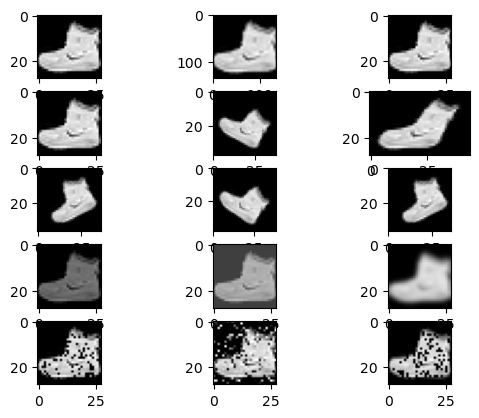

In [151]:
fig, ax = plt.subplots(5,3)
ax[0,0].imshow(tr_images[0], cmap='gray', vmin=0, vmax=255)
ax[0,1].imshow(scale_aug.augment_image(tr_images[0].numpy()), cmap='gray', vmin=0, vmax=255)
ax[0,2].imshow(transx_aug.augment_image(tr_images[0].numpy()), cmap='gray', vmin=0, vmax=255)
ax[1,0].imshow(transxy_aug.augment_image(tr_images[0].numpy()), cmap='gray', vmin=0, vmax=255)
ax[1,1].imshow(rotate_aug.augment_image(tr_images[0].numpy()), cmap='gray', vmin=0, vmax=255)
ax[1,2].imshow(shear_aug.augment_image(tr_images[0].numpy()), cmap='gray', vmin=0, vmax=255)

for i in range(3):
    ax[2,i].imshow(multiple_rotation.augment_image(tr_images[0].numpy()), cmap='gray', vmin=0, vmax=255)

ax[3,0].imshow(mul_aug.augment_image(tr_images[0].numpy()), cmap='gray', vmin=0, vmax=255)
ax[3,1].imshow(linear_aug.augment_image(tr_images[0].numpy()), cmap='gray', vmin=0, vmax=255)

ax[3,2].imshow(guassian_aug.augment_image(tr_images[0].numpy()), cmap='gray', vmin=0, vmax=255)

ax[4,0].imshow(dropout_aug.augment_image(tr_images[0].numpy()), cmap='gray', vmin=0, vmax=255)
ax[4,1].imshow(saltandpepper_aug.augment_image(tr_images[0].numpy()), cmap='gray', vmin=0, vmax=255)

ax[4,2].imshow(seq.augment_image(tr_images[0].numpy()), cmap='gray', vmin=0, vmax=255)

In [160]:
aug = iaa.Sequential([
    iaa.Affine(translate_px={'x':0}, mode='constant'),
    iaa.Affine(rotate=45)
])

class FMNISTDataSet(Dataset):
    def __init__(self, x, y, aug=None):
        self.x, self.y = x, y
        self.aug = aug
    
    def __getitem__(self, index): return self.x[index], self.y[index]

    def __len__(self): return len(self.x)

    def collate_fn(self, batch):
        ims, classes = zip(*batch)
        ims = [im.numpy() for im in ims]
        if self.aug: ims=self.aug.augment_images(images=ims)
        ims = torch.tensor(ims)[:, None, :, :]/255
        classes = torch.tensor(classes)
        return ims, classes
    
train = FMNISTDataSet(tr_images, tr_targets, aug=aug)
tran_dl = DataLoader(train, 64, collate_fn=train.collate_fn)





class FMNISTDataSet2(Dataset):
    def __init__(self, x, y, transform=None):
        self.x, self.y = x, y
        self.transform = transform
    
    def __getitem__(self, index): 
        if self.transform:
            x = self.transform(self.x[index])
        return x, self.y[index]

    def __len__(self): return len(self.x)


transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomAffine(degrees=1, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=10),
    transforms.RandomRotation(degrees=45),
    transforms.ToTensor()
])

train2 = FMNISTDataSet2(tr_images, tr_targets, transform=transform)
train_dl2 = DataLoader(train2, 64)

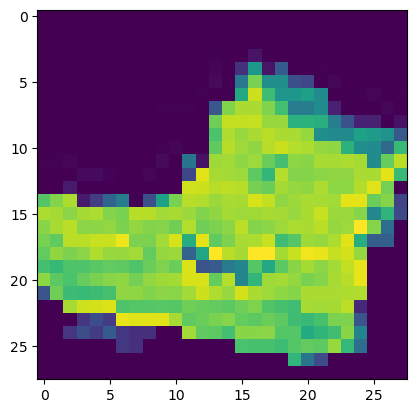

In [167]:
example = iter(train_dl2)
img, tr = example._next_data()
plt.imshow(img[0].numpy().squeeze())

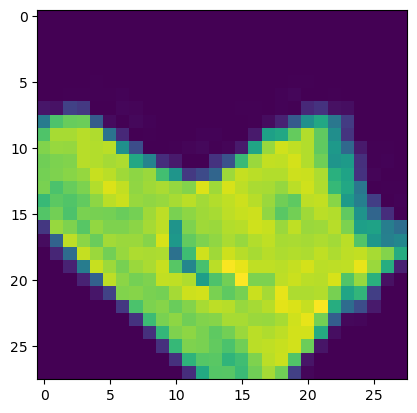

In [166]:
example = iter(tran_dl)
img, tr = example._next_data()
plt.imshow(img[0].numpy().squeeze())